<a href="https://colab.research.google.com/github/pr-shukla/MS-Thesis/blob/main/intelligent_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
import tensorflow.keras as K
from tensorflow.keras.models import load_model
#import tensorflow.random_uniform_initializer as I

In [ ]:
actor_model = load_model('actor_model.h5')

In [ ]:
#Dimension of State Space
dim_state = 6

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.4

#Number of Episodes
num_episodes = 100

#Number of Steps
num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 0.3

#Minimum Turning radius of evader
rhoe = 0.3


#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 1.0

#angle between initial velocity and reference
te = 3*np.pi/4

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model_e(state_batch)*2 - 1.0
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model_e.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model_e.trainable_variables)
        )


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model_e.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

In [ ]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-3e-6, maxval=3e-6)

    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(512, activation="selu", kernel_initializer=last_init)(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    '''
    out = layers.Dense(256, activation="selu", kernel_initializer=last_init)(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    '''
    outputs = layers.Dense(1, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = K.Model(inputs, outputs)
    return model

def get_critic():
    last_init = tf.random_uniform_initializer(minval=-3e-6, maxval=3e-6)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(32, activation="selu", kernel_initializer=last_init)(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(64, activation="selu", kernel_initializer=last_init)(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(64, activation="selu", kernel_initializer=last_init)(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(1024, activation="selu", kernel_initializer=last_init)(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(1024, activation="selu", kernel_initializer=last_init)(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = K.Model([state_input, action_input], outputs)

    return model

In [ ]:

def policy_e(state, noise_object):
    
    sampled_actions = tf.squeeze(actor_model_e(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy()*2 + noise - 1.0

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model_e = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model_e.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 1e-7
actor_lr = 5e-8

critic_optimizer = K.optimizers.Adam(critic_lr)
actor_optimizer = K.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(20000, 128)

In [ ]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(state):
    L = np.sqrt((state[4] - state[0])**2 + (state[5]-state[1])**2)
    return L

#Magnitude of Velocity Calculator
def V(state):
    v = np.sqrt(state[2]**2+state[3]**2)
    return v

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
    r1 = 10*state[0]#-10*np.exp(-3*state[0])
    #r2 = 10*state[1]#-10*np.exp(-1*state[1])
    #r3 = -5*np.arctan(state[2])
    r4 = 10*state[3]
    r =  r1 + r4#+ r2  #+ r3 
    return r

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(state):
    x_pursuer = state[0]
    y_pursuer = state[1]
    x_evader = state[4]
    y_evader = state[5]
    
    x_velocity_pursuer = state[2]
    y_velocity_pursuer = state[3]
    
    x_evader_pursuer = x_evader - x_pursuer
    y_evader_pursuer = y_evader - y_pursuer
    
    d = L(state)
    
    angle = math.acos(round((x_evader_pursuer*x_velocity_pursuer+ y_evader_pursuer*y_velocity_pursuer)/d, 4))
    
    return angle

# Transition from Current State to New State
def transitionme(pursuer_state1, pursuer_state2, state1, state2, u1, u2, ue,
                 fake_state, theta_velocity_e, theta_velocity_p1,
                 theta_velocity_p2, evader_state_e, state_e1, state_e2): 

    old_phi1 = phi(state1)
    old_phi2 = phi(state2)
    old_phi_e1 = phi(state_e1)
    old_phi_e2 = phi(state_e2)

    #Change in x and y position of Pursuer
    del_xp1 = state1[2]*dt
    del_yp1 = state1[3]*dt
    del_xp2 = state2[2]*dt
    del_yp2 = state2[3]*dt
    
    #Change in x and y position of Evader
    del_xe = fake_state[2]*dt
    del_ye = fake_state[3]*dt
    
    #Change in Angle between velocity and reference axis
    del_theta_velocity_p1 = (v/rho)*u1*dt
    theta_velocity_p1 = theta_velocity_p1 + del_theta_velocity_p1
    del_theta_velocity_p2 = (v/rho)*u2*dt
    theta_velocity_p2 = theta_velocity_p2 + del_theta_velocity_p2
    
    #Change in Angle between evader velocity and reference axis
    del_theta_velocity_e = (ve/rhoe)*ue*dt
    theta_velocity_e = theta_velocity_e + del_theta_velocity_e
    
    #New x and y position of Pursuer
    state1[0] = state1[0] + del_xp1
    state1[1] = state1[1] + del_yp1
    
    #New x and y position of Evader
    state1[4] = state1[4] + del_xe
    state1[5] = state1[5] + del_ye

    #New x and y position of Pursuer
    state2[0] = state2[0] + del_xp2
    state2[1] = state2[1] + del_yp2
    
    #New x and y position of Evader
    state2[4] = state2[4] + del_xe
    state2[5] = state2[5] + del_ye
    
    #New x and y velocity of Pursuer
    state1[2] = 1.0*np.cos(theta_velocity_p1)
    state1[3] = 1.0*np.sin(theta_velocity_p1)
    
    state2[2] = 1.0*np.cos(theta_velocity_p2)
    state2[3] = 1.0*np.sin(theta_velocity_p2)
    
    v_e = [0,0]
    #New velocity of evader
    v_e[0] = ve*np.cos(theta_velocity_e)
    v_e[1] = ve*np.sin(theta_velocity_e)
    
    fake_state[2] = v_e[0]
    fake_state[3] = v_e[1]
    
    new_phi1 = phi(state1)
    new_phi2 = phi(state2)
    new_phi_e1 = phi(state_e1)
    new_phi_e2 = phi(state_e2)

    p_state1 = [0,0,0]
    
    #New phi and phi(dot)
    p_state1[1] = phi(state1)/np.pi
    #p_state[1] = (del_theta_velocity_p/dt)/(2*np.pi)
    p_state1[0] = L(state1)/30.0
    p_state1[2] = (new_phi1-old_phi1)/dt

    p_state2 = [0,0,0]
    
    #New phi and phi(dot)
    p_state2[1] = phi(state2)/np.pi
    #p_state[1] = (del_theta_velocity_p/dt)/(2*np.pi)
    p_state2[0] = L(state2)/30.0
    p_state2[2] = (new_phi2-old_phi2)/dt


    for i in range(len(state_e1)):
      state_e1[-1-i] = state1[i]

    for i in range(len(state_e2)):
      state_e2[-1-i] = state2[i]
    p_state_e = [0,0,0,0,0,0]


    p_state_e[0] = L(state_e1)/30.0
    p_state_e[1] = phi(state_e1)/np.pi
    p_state_e[2] = (new_phi_e1-old_phi_e1)/dt
    p_state_e[0] = L(state_e2)/30.0
    p_state_e[1] = phi(state_e2)/np.pi
    p_state_e[2] = (new_phi_e2-old_phi_e2)/dt
    
    return (p_state1, p_state2, state1, state2, fake_state, theta_velocity_e, theta_velocity_p1,
    theta_velocity_p2, p_state_e, state_e1, state_e2)

In [ ]:
'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''

def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() #+ noise

    return [sampled_actions]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(num_episodes):
    
    velocity_evader = [ve*np.cos(te), ve*np.sin(te)]

    sys_state1 = [5.0,0.0,1.0,0.0,5.0,5.0]
    prev_state1 = np.array([L(sys_state1)/30.0, phi(sys_state1)/np.pi,0])#, abs(alph(sys_state))/(2*np.pi)])
    fake_state1 = [0.0, 0.0, velocity_evader[0], velocity_evader[1], 0.0, 0.0]
    theta_velocity_e1 = thetap(fake_state1)
    theta_velocity_p1 = thetap(sys_state1)

    sys_state2 = [-15.0,10.0,1.0,0.0,5.0,5.0]
    prev_state2 = np.array([L(sys_state2)/30.0, phi(sys_state2)/np.pi,0])
    fake_state2 = [0.0, 0.0, velocity_evader[0], velocity_evader[1], 0.0, 0.0]
    theta_velocity_e2 = thetap(fake_state2)
    theta_velocity_p2 = thetap(sys_state2)
    

    sys_state_e1 = [5.0,5.0,ve*np.cos(te), ve*np.sin(te),5.0,0.0]
    sys_state_e2 = [5.0,5.0,ve*np.cos(te), ve*np.sin(te),-15.0,10.0]
    prev_state_e = np.array([L(sys_state_e1)/30.0, phi(sys_state_e1)/np.pi,0,
                             L(sys_state_e2)/30.0, phi(sys_state_e2)/np.pi,0])
    
    
    
    episodic_reward = 0
    
    xc1 = []
    yc1 = []

    xc2 = []
    yc2 = []
    
    
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state1 = tf.expand_dims(tf.convert_to_tensor(prev_state1), 0) 
        tf_prev_state2 = tf.expand_dims(tf.convert_to_tensor(prev_state2), 0)
        tf_prev_state_e = tf.expand_dims(tf.convert_to_tensor(prev_state_e), 0) 

        action1 = policy(tf_prev_state1)
        action2 = policy(tf_prev_state2)
        action = policy_e(tf_prev_state_e, ou_noise)
        # Recieve state and reward from environment.
        new_state1, new_state2, sys_state1, sys_state2, fake_state1,theta_velocity_e1,theta_velocity_p1, theta_velocity_p2, new_state_e, sys_state_e1, sys_state_e2 = transitionme(
            prev_state1, prev_state2, sys_state1, sys_state2, float(action1[0]), float(action2[0]), float(action[0]),
                fake_state1, theta_velocity_e1, theta_velocity_p1,
                theta_velocity_p2, prev_state_e, sys_state_e1, sys_state_e2)
        
        
        rew = reward(new_state_e)
        episodic_reward += rew

        buffer.record((prev_state_e, action, rew, new_state_e))
        buffer.learn()
        update_target(tau)
        '''       
        if L(sys_state1) <= 0.2:
            print ('****TARGET CAPTURED****')
            print('Captured after', i+1, 'steps')
            break
        '''        
        prev_state1 = new_state1
        prev_state2 = new_state2
        prev_state_e = new_state_e
        xc1.append(sys_state1[0])
        yc1.append(sys_state1[1])

        xc2.append(sys_state2[0])
        yc2.append(sys_state2[1])
        
        xce.append(sys_state1[4])
        yce.append(sys_state1[5])
        
    xc_final = [sys_state1[4]]
    yc_final = [sys_state1[5]]

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc1,yc1, label = 'Pursuer Trajectory', color = 'blue')
    plt.plot(xc2,yc2, label = 'Pursuer Trajectory', color = 'blue')
    plt.plot(xce,yce, label = 'Target Trajectory', color = 'green')
    plt.plot(xc_final,yc_final,'*', label = 'Target Final Position', color = 'red')
    plt.legend()
    title = 'Episode Number', ep+1
    #plt.title(title)
    #plt.savefig('3_pur_man_ev__.jpg',dpi=1000)
    plt.show()

'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''

KeyboardInterrupt: ignored

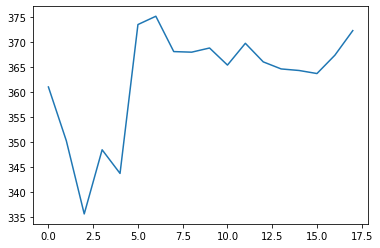

In [ ]:
plt.plot(avg_reward_list)

In [ ]:
actor_model_e.save('actor_model_e.h5')

Episode * 0 * Avg Reward is ==> 455.6852996815937


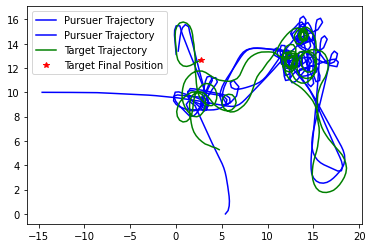

'\n*************************************\nModel Cheker for maneuvering evader\n*************************************\n\n'

In [ ]:
'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''

#ve = 1.0
#rhoe = 0.1
def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() #+ noise

    return [sampled_actions]

'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''

def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() #+ noise

    return [sampled_actions]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(1):
    
    velocity_evader = [ve*np.cos(te), ve*np.sin(te)]

    sys_state1 = [5.0,0.0,1.0,0.0,5.0,5.0]
    prev_state1 = np.array([L(sys_state1)/30.0, phi(sys_state1)/np.pi,0])#, abs(alph(sys_state))/(2*np.pi)])
    fake_state1 = [0.0, 0.0, velocity_evader[0], velocity_evader[1], 0.0, 0.0]
    theta_velocity_e1 = thetap(fake_state1)
    theta_velocity_p1 = thetap(sys_state1)

    sys_state2 = [-15.0,10.0,1.0,0.0,5.0,5.0]
    prev_state2 = np.array([L(sys_state2)/30.0, phi(sys_state2)/np.pi,0])
    fake_state2 = [0.0, 0.0, velocity_evader[0], velocity_evader[1], 0.0, 0.0]
    theta_velocity_e2 = thetap(fake_state2)
    theta_velocity_p2 = thetap(sys_state2)
    

    sys_state_e1 = [5.0,5.0,ve*np.cos(te), ve*np.sin(te),5.0,0.0]
    sys_state_e2 = [5.0,5.0,ve*np.cos(te), ve*np.sin(te),-15.0,10.0]
    prev_state_e = np.array([L(sys_state_e1)/30.0, phi(sys_state_e1)/np.pi,0,
                             L(sys_state_e2)/30.0, phi(sys_state_e2)/np.pi,0])
    
    
    
    episodic_reward = 0
    
    xc1 = []
    yc1 = []

    xc2 = []
    yc2 = []
    
    
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state1 = tf.expand_dims(tf.convert_to_tensor(prev_state1), 0) 
        tf_prev_state2 = tf.expand_dims(tf.convert_to_tensor(prev_state2), 0)
        tf_prev_state_e = tf.expand_dims(tf.convert_to_tensor(prev_state_e), 0) 

        action1 = policy(tf_prev_state1)
        action2 = policy(tf_prev_state2)
        action = policy_e(tf_prev_state_e, ou_noise)
        # Recieve state and reward from environment.
        new_state1, new_state2, sys_state1, sys_state2, fake_state1,theta_velocity_e1,theta_velocity_p1, theta_velocity_p2, new_state_e, sys_state_e1, sys_state_e2 = transitionme(
            prev_state1, prev_state2, sys_state1, sys_state2, float(action1[0]), float(action2[0]), float(action[0]),
                fake_state1, theta_velocity_e1, theta_velocity_p1,
                theta_velocity_p2, prev_state_e, sys_state_e1, sys_state_e2)
        
        
        rew = reward(new_state_e)
        episodic_reward += rew

        #buffer.record((prev_state_e, action, rew, new_state_e))
        #buffer.learn()
        #update_target(tau)
        '''       
        if L(sys_state1) <= 0.2:
            print ('****TARGET CAPTURED****')
            print('Captured after', i+1, 'steps')
            break
        '''        
        prev_state1 = new_state1
        prev_state2 = new_state2
        prev_state_e = new_state_e
        xc1.append(sys_state1[0])
        yc1.append(sys_state1[1])

        xc2.append(sys_state2[0])
        yc2.append(sys_state2[1])
        
        xce.append(sys_state1[4])
        yce.append(sys_state1[5])
        
    xc_final = [sys_state1[4]]
    yc_final = [sys_state1[5]]

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc1,yc1, label = 'Pursuer Trajectory', color = 'blue')
    plt.plot(xc2,yc2, label = 'Pursuer Trajectory', color = 'blue')
    plt.plot(xce,yce, label = 'Target Trajectory', color = 'green')
    plt.plot(xc_final,yc_final,'*', label = 'Target Final Position', color = 'red')
    plt.legend()
    title = 'Episode Number', ep+1
    #plt.title(title)
    #plt.savefig('3_pur_man_ev__.jpg',dpi=1000)
    plt.show()

'''
*************************************
Model Cheker for maneuvering evader
*************************************

'''


In [ ]:
from matplotlib import animation

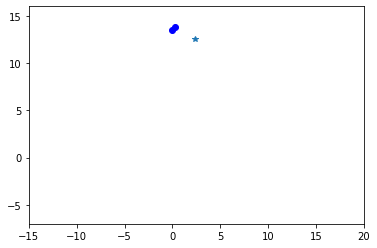

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-15, 20), ylim=(-7, 16))
line, = ax.plot([], [], 'bo')
line1, = ax.plot([], [], 'bo')
line2, = ax.plot([], [], '*')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    return line, line1, line2,

# animation function.  This is called sequentially
def animate(i):
    x = xc1[i-1:i]
    y = yc1[i-1:i]
    x2 = xc2[i-1:i]
    y2 = yc2[i-1:i]
    x_ = xce[i-1:i]
    y_ = yce[i-1:i]
    line.set_data(x, y)
    line1.set_data(x2, y2)
    line2.set_data(x_, y_)
    return line, line1, line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=1, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

plt.show()